In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%load_ext rpy2.ipython

# Import scripts

In [4]:
path_scripts = '/Users/simjoo/Projects/10X_aging/scripts/v3/'

In [5]:
import sys
sys.path.append(path_scripts)

In [6]:
from ipyparallel import Client
import csv
import os
import pickle
import scipy.io
import scanpy as sc
import anndata
import bbknn
import statsmodels.api as sm
#import diffxpy.api as de
import scanpy.external as sce
import gseapy as gp
#import ternary

In [7]:
from TenX_aging_misc_scripts_v1_0 import *
from TenX_aging_plot_v1_0 import *
from TenX_aging_mann_whitney_u_v1_0 import *

In [8]:
#exp_id = create_ID()

In [9]:
exp_id = '202111251525'
path_input = '/Users/simjoo/Projects/10X_aging/data_input/'
path_output = '/Users/simjoo/Projects/10X_aging/data_output/v3/'
path_figures = '/Users/simjoo/Projects/10X_aging/figures/v3/'

In [10]:
cmap_tab20 = {str(c) : mpl.colors.rgb2hex(plt.cm.tab20(c/20)) for c in range(20)}
cmap_tissue = {'KP':'#e31a1c', 'KPL':'#1f78b4', 'KPLR':'#ff7f00', 'KPR':'#6a3d9a', 'KPT':'#e7298a', 'healthy':'#33a02c'}
cmap_age = {'young': '#377eb8', 'aged': '#e41a1c'}
cmap_tumor_age = {'KP_young':'#fb9a99','KP_aged':'#e31a1c',
                  'KPL_young':'#a6cee3','KPL_aged':'#1f78b4',
                  'KPLR_young':'#fdbf6f','KPLR_aged':'#ff7f00',
                  'KPR_young':'#cab2d6','KPR_aged':'#6a3d9a',
                  'KPT_young':'#e78ac3','KPT_aged':'#e7298a',
                  'healthy_young':'#b2df8a','healthy_aged':'#33a02c'}
cmap_tumor_stage = {'healthy':'#33a02c',
                    '4wk':'#1f78b4',
                    '12wk':'#6a3d9a',
                    '17-18wk':'#ff7f00',
                    '19-20wk':'#e31a1c',}
cmap_epithelial_tumor = {'AT2-like': '#b2df8a',
                         'AT2': '#33a02c',
                         'High plasticity cell state': '#a50f15',
                         'AT1-like': '#fb6a4a',
                         'Ribosome high': '#c51b7d',
                         'Endoderm-like': '#542788',
                         'AT1': '#e6ab02',
                         'Ciliated':'#666666', 
                         'Other':'silver'}

In [11]:
def draw_violin(data, groups, cmap=plt.cm.tab20, gr_order=None, scatter=False):
    
    L = len(set(groups))
    
    if not gr_order:
        gr_order = return_unique(groups)
    
    #initialize figure

    height = 6
    width = 2 * L

    plt.figure(facecolor = 'w', figsize = (width, height))
    
    #define colormap
    
    if type(cmap) != dict:
        cm = cmap
        cmap = {}
        for ix, gr in enumerate(return_unique(groups)):
            cmap[gr] = cm(float(ix) / 20)
            
    clist = [cmap[groups[c]] for c in groups.index]

    #define x and y axes

    ax = plt.subplot()

    ax.set_xlim(-0.5, L-0.5)
    ax.set_xticks(range(L))
    ax.set_xticklabels(gr_order, family = 'Arial', fontsize = 20, rotation = 'vertical')

    ax.set_ylim(data.values.min(), data.max())
    ax.set_ylabel('Expression', family = 'Arial', fontsize = 20)
    for tick_pos, tick in enumerate(ax.yaxis.get_major_ticks()):
            ax.yaxis.get_major_ticks()[tick_pos].label.set_family('Arial')
            ax.yaxis.get_major_ticks()[tick_pos].label.set_fontsize(15)

    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    
    #plot data

    for p, i in enumerate(gr_order):

        i_tmp = groups[groups==i].index
        d_tmp = data[i_tmp].values
        
        if scatter:
            ax.scatter([p-(i-0.5)/2 for i in np.random.rand(len(d_tmp), 1)],
                        d_tmp,
                        color = 'k',
                        s = 1,
                        alpha = 0.25,
                        zorder = 1)

        violin = ax.violinplot([d_tmp],
                                positions = [p],
                                vert=True,
                                showextrema=False,
                                widths=0.75)

        for v in violin['bodies']:
            v.set_facecolor(cmap[i])
            v.set_linewidth(0)
            v.set_alpha(0.75)
            v.set_zorder(0)

        ax.plot([p-0.25,p+0.25],[np.mean(d_tmp),np.mean(d_tmp)], color = 'k', linewidth = 2)
        
    ax.text((ax.get_xlim()[1]-0.5)/2,
            ax.get_ylim()[1]*1.05,
            data.name, 
            fontsize=25, family='Arial', va='center', ha='center')

# Initialize engines

In [12]:
c = Client()

/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/ipyparallel/client/client.py:466: RuntimeWarning: 
            Controller appears to be listening on localhost, but not on this machine.
            If this is true, you should specify Client(...,sshserver='you@bionut2400.local')
            or instruct your controller to listen on an external IP.
  RuntimeWarning)


TimeoutError: Hub connection request timed out

In [ ]:
dview = c[:]

In [ ]:
dview.execute('import sys')
dview.execute('sys.path.append("/Users/simjoo/Projects/10X_aging/scripts/v3/")')
dview.execute('from TenX_aging_misc_scripts_v1_0 import *')
dview.execute('from TenX_aging_plot_v1_0 import *')
dview.execute('from TenX_aging_mann_whitney_u_v1_0 import *')

## Import gene signatures generated by Qing Wang

In [12]:
genes_MAST = pd.read_excel('%s/MAST_tumorcells_nohealthy_agedvsyoung_addribo.xls'%path_output,
                         header=0, index_col=1)

In [13]:
np.sum(genes_MAST['Pr(>Chisq)']<0.05)

3129

In [14]:
genes_young = genes_MAST['names'][(genes_MAST['coef']<-0.1)&(genes_MAST['Pr(>Chisq)']<0.05)].values

In [15]:
len(genes_young)

1193

In [16]:
genes_aged = genes_MAST['names'][(genes_MAST['coef']>0.1)&(genes_MAST['Pr(>Chisq)']<0.05)].values

In [17]:
len(genes_aged)

739

# EnrichR

## MSigDB_Hallmark_2020

In [21]:
enr_young = gp.enrichr(gene_list=list(genes_young),
                       gene_sets='MSigDB_Hallmark_2020',
                       organism='Mouse',
                       cutoff=0.1,
                       no_plot=True,)

In [22]:
enr_young.res2d.to_csv('%s/MSigDB_Hallmark_2020_young.csv' % path_output)

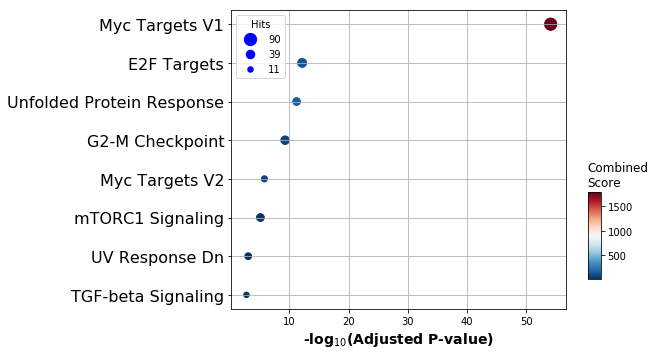

In [23]:
gp.plot.dotplot(enr_young.res2d, top_term=20)

In [24]:
enr_aged = gp.enrichr(gene_list=list(genes_aged),
                      gene_sets='MSigDB_Hallmark_2020',
                      organism='Mouse',
                      cutoff=0.1,
                      no_plot=True,)

In [25]:
enr_aged.res2d.to_csv('%s/MSigDB_Hallmark_2020_aged.csv' % path_output)

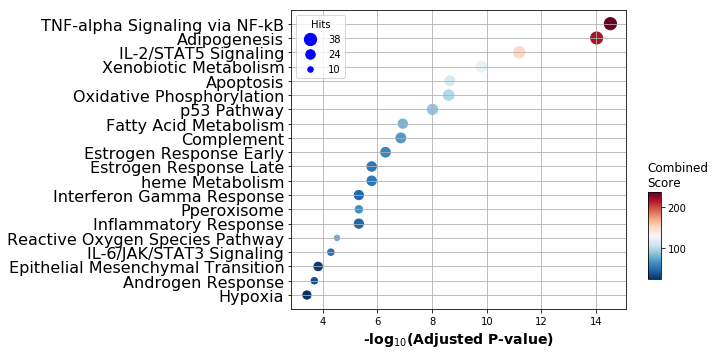

In [26]:
gp.plot.dotplot(enr_aged.res2d, top_term=20)

## KEGG_2019_Mouse

In [27]:
enr_young = gp.enrichr(gene_list=list(genes_young),
                       gene_sets='KEGG_2019_Mouse',
                       organism='Mouse',
                       cutoff=0.1,
                       no_plot=True,)

In [28]:
enr_young.res2d.to_csv('%s/KEGG_2019_Mouse_young.csv' % path_output)

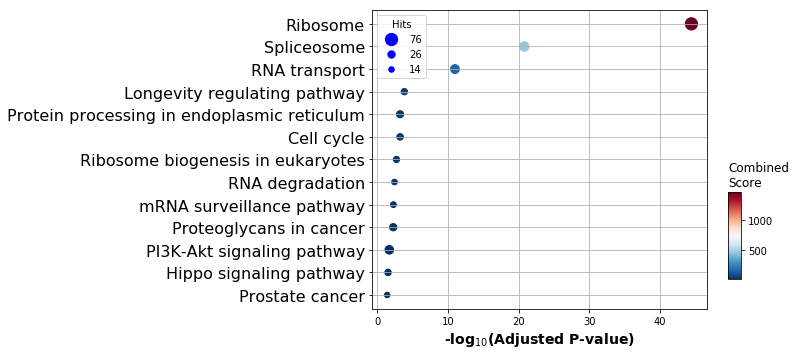

In [29]:
gp.plot.dotplot(enr_young.res2d, top_term=20)

In [30]:
enr_aged = gp.enrichr(gene_list=list(genes_aged),
                      gene_sets='KEGG_2019_Mouse',
                      organism='Mouse',
                      cutoff=0.1,
                      no_plot=True,)

In [31]:
enr_aged.res2d.to_csv('%s/KEGG_2019_Mouse_aged.csv' % path_output)

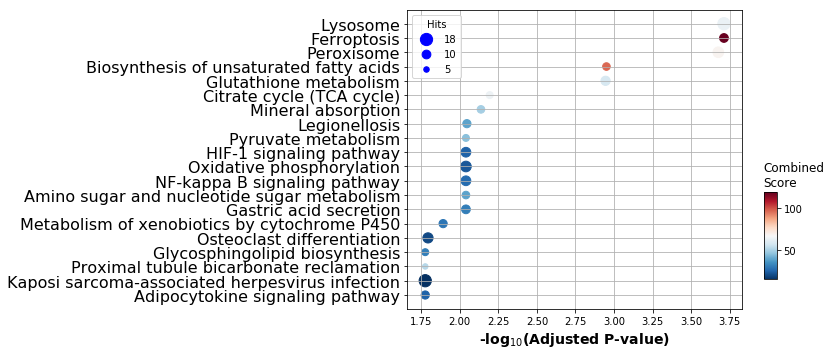

In [32]:
gp.plot.dotplot(enr_aged.res2d, top_term=20)

## Reactome_2022

In [33]:
enr_young = gp.enrichr(gene_list=list(genes_young),
                       gene_sets='Reactome_2022',
                       organism='Mouse',
                       cutoff=0.1,
                       no_plot=True,)

In [34]:
enr_young.res2d.to_csv('%s/Reactome_2022_young.csv' % path_output)

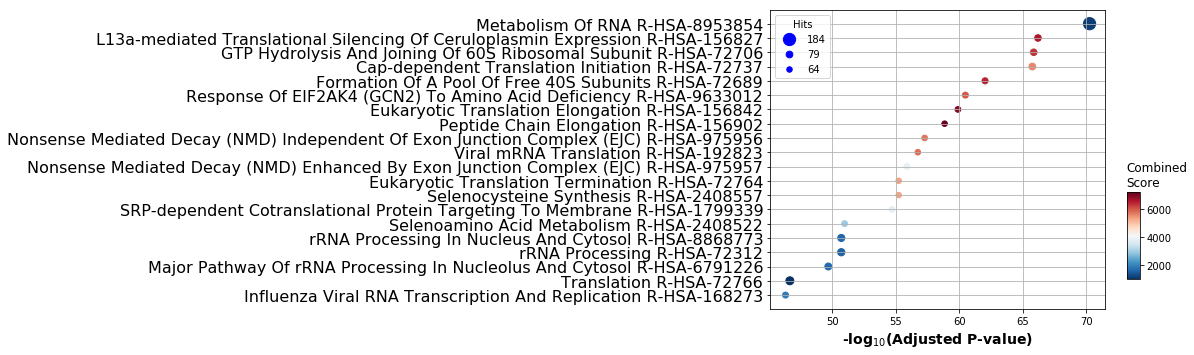

In [35]:
gp.plot.dotplot(enr_young.res2d, top_term=20)

In [36]:
enr_aged = gp.enrichr(gene_list=list(genes_aged),
                      gene_sets='Reactome_2022',
                      organism='Mouse',
                      cutoff=0.1,
                      no_plot=True,)

In [37]:
enr_aged.res2d.to_csv('%s/Reactome_2022_aged.csv' % path_output)

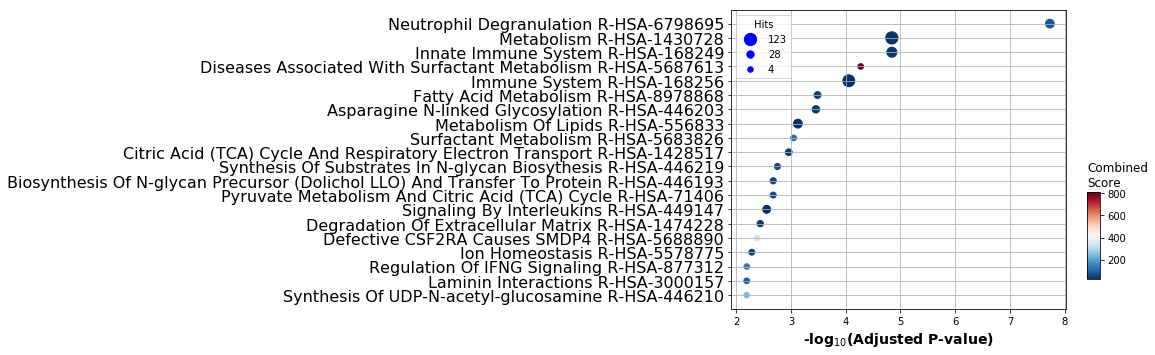

In [38]:
gp.plot.dotplot(enr_aged.res2d, top_term=20)

## BioCarta_2016

In [39]:
enr_young = gp.enrichr(gene_list=list(genes_young),
                       gene_sets='BioCarta_2016',
                       organism='Mouse',
                       cutoff=0.1,
                       no_plot=True,)

In [40]:
enr_young.res2d.to_csv('%s/BioCarta_2016_young.csv' % path_output)

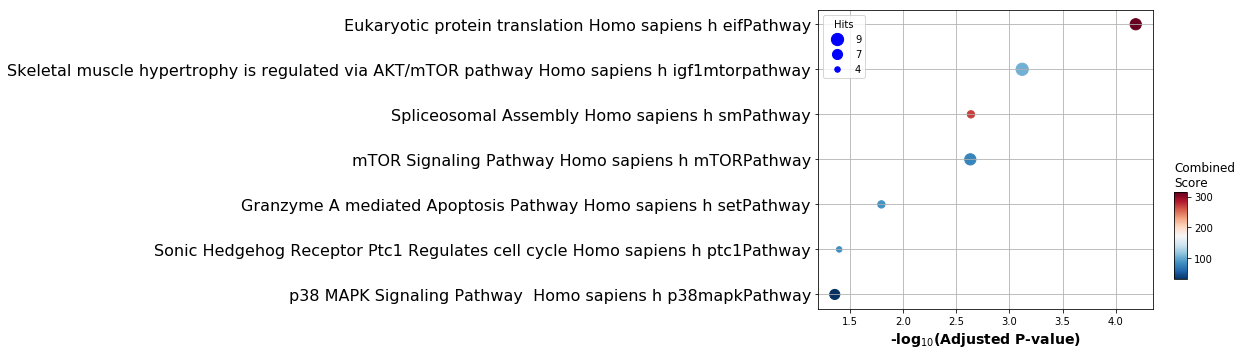

In [41]:
gp.plot.dotplot(enr_young.res2d, top_term=20)

In [42]:
enr_aged = gp.enrichr(gene_list=list(genes_aged),
                      gene_sets='BioCarta_2016',
                      organism='Mouse',
                      cutoff=0.1,
                      no_plot=True,)

In [43]:
enr_aged.res2d.to_csv('%s/BioCarta_2016_aged.csv' % path_output)

In [44]:
gp.plot.dotplot(enr_aged.res2d, top_term=20)

'Warning: No enrich terms when cutoff = 0.05'

## GO_Biological_Process_2021

In [30]:
enr_young = gp.enrichr(gene_list=list(genes_young),
                       gene_sets='GO_Biological_Process_2021',
                       organism='Mouse',
                       cutoff=0.1,
                       no_plot=True,)

In [46]:
enr_young.res2d.to_csv('%s/GO_Biological_Process_2021_young.csv' % path_output)

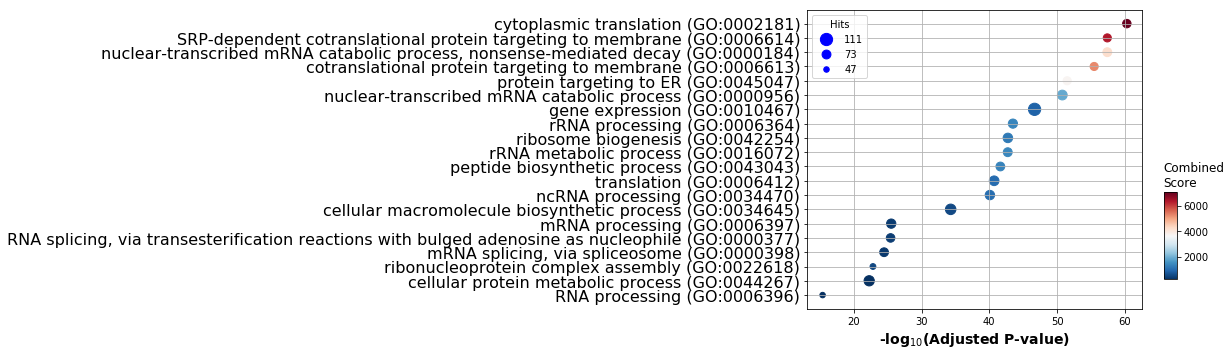

In [47]:
gp.plot.dotplot(enr_young.res2d, top_term=20)

In [48]:
enr_aged = gp.enrichr(gene_list=list(genes_aged),
                      gene_sets='GO_Biological_Process_2021',
                      organism='Mouse',
                      cutoff=0.1,
                      no_plot=True,)

In [49]:
enr_aged.res2d.to_csv('%s/GO_Biological_Process_2021_aged.csv' % path_output)

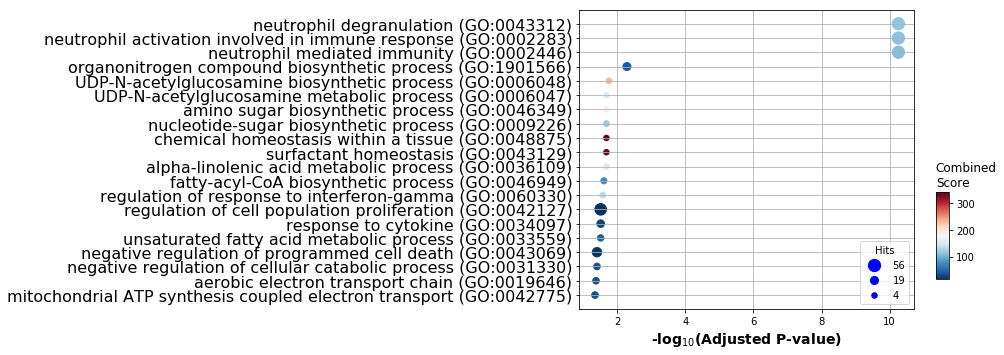

In [50]:
gp.plot.dotplot(enr_aged.res2d, top_term=20)

# Prerank (based on fold change / MAST coef)

In [18]:
genes_prer = genes_MAST['coef'][genes_MAST['Pr(>Chisq)']<0.05].sort_values(ascending=True) * (-1)
genes_prer.index = [i.upper() for i in genes_prer.index]

## MSigDB_Hallmark_2020

In [19]:
pre_res = gp.prerank(rnk=genes_prer,
                     gene_sets='MSigDB_Hallmark_2020',
                     min_size=5,
                     max_size=1000,
                     permutation_num=1000, # reduce number to speed up testing
                     outdir=None, # don't write to disk
                     seed=6,
                     verbose=True)

2022-11-22 16:28:11,298 Parsing data files for GSEA.............................
2022-11-22 16:28:12,087 Enrichr library gene sets already downloaded in: /Users/simjoo/.cache/gseapy, use local file
2022-11-22 16:28:12,964 0000 gene_sets have been filtered out when max_size=1000 and min_size=5
2022-11-22 16:28:12,964 0050 gene_sets used for further statistical testing.....
2022-11-22 16:28:12,967 Start to run GSEA...Might take a while..................
2022-11-22 16:28:24,618 Start to generate gseapy reports, and produce figures...
2022-11-22 16:28:24,652 Congratulations. GSEApy runs successfully................



In [20]:
pre_res_iron = pd.DataFrame(columns=pre_res.res2d.columns)
pre_res_iron.loc['Heme Metabolism (Hallmark)'] = pre_res.res2d.loc['heme Metabolism']

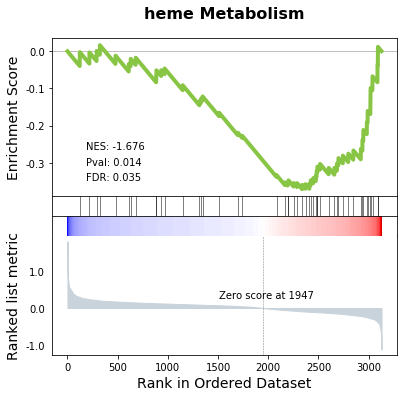

In [21]:
term = 'heme Metabolism'
gp.gseaplot(rank_metric=pre_res.ranking,
            term=term,
            cmap = plt.cm.seismic_r,
            **pre_res.results[term])
figname = 'gseaplot_Hallmark_heme_metabolism.png'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'png',
            dpi=300,
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

## KEGG_2019_Mouse

In [21]:
pre_res = gp.prerank(rnk=genes_prer,
                     gene_sets='KEGG_2019_Mouse',
                     min_size=5,
                     max_size=1000,
                     permutation_num=1000, # reduce number to speed up testing
                     outdir=None, # don't write to disk
                     seed=6,
                     verbose=True)

2022-11-22 16:28:25,006 Parsing data files for GSEA.............................
2022-11-22 16:28:25,609 Enrichr library gene sets already downloaded in: /Users/simjoo/.cache/gseapy, use local file
2022-11-22 16:28:28,636 0044 gene_sets have been filtered out when max_size=1000 and min_size=5
2022-11-22 16:28:28,637 0259 gene_sets used for further statistical testing.....
2022-11-22 16:28:28,639 Start to run GSEA...Might take a while..................
2022-11-22 16:29:28,337 Start to generate gseapy reports, and produce figures...
2022-11-22 16:29:28,581 Congratulations. GSEApy runs successfully................



In [22]:
pre_res_iron.loc['Ferroptosis (KEGG)'] = pre_res.res2d.loc['Ferroptosis']
pre_res_iron.loc['Mineral absorption (KEGG)'] = pre_res.res2d.loc['Mineral absorption']

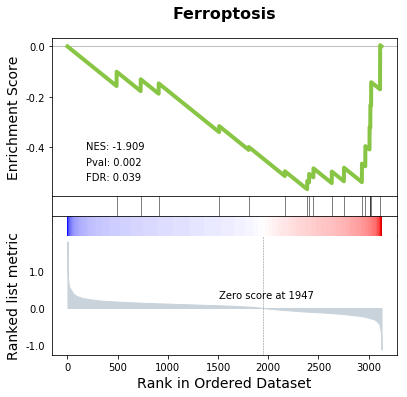

In [24]:
term = 'Ferroptosis'
gp.gseaplot(rank_metric=pre_res.ranking,
         term=term,
            cmap = plt.cm.seismic_r,
         **pre_res.results[term])
figname = 'gseaplot_KEGG_ferroptosis.png'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'png',
            dpi=300,
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

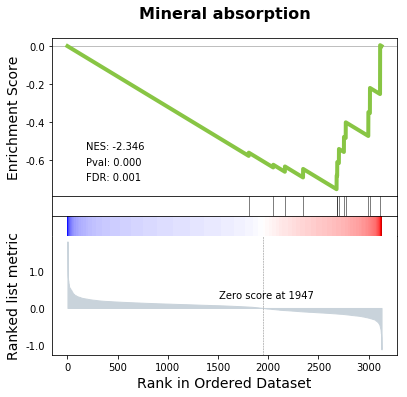

In [25]:
term = 'Mineral absorption'
gp.gseaplot(rank_metric=pre_res.ranking,
         term=term,
            cmap = plt.cm.seismic_r,
         **pre_res.results[term])
figname = 'gseaplot_KEGG_Mineral absorption.png'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'png',
            dpi=300,
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

## GO_Biological_Process_2021

In [23]:
pre_res = gp.prerank(rnk=genes_prer,
                     gene_sets='GO_Biological_Process_2021',
                     min_size=5,
                     max_size=1000,
                     permutation_num=1000, # reduce number to speed up testing
                     outdir=None, # don't write to disk
                     seed=6,
                     verbose=True)

2022-11-22 16:29:29,634 Parsing data files for GSEA.............................
2022-11-22 16:29:30,370 Enrichr library gene sets already downloaded in: /Users/simjoo/.cache/gseapy, use local file
2022-11-22 16:29:54,200 3919 gene_sets have been filtered out when max_size=1000 and min_size=5
2022-11-22 16:29:54,202 2117 gene_sets used for further statistical testing.....
2022-11-22 16:29:54,203 Start to run GSEA...Might take a while..................
2022-11-22 16:41:26,836 Start to generate gseapy reports, and produce figures...
2022-11-22 16:41:31,843 Congratulations. GSEApy runs successfully................



In [24]:
pre_res_iron.loc['iron ion transport (GOBP)'] = pre_res.res2d.loc['iron ion transport (GO:0006826)']
pre_res_iron.loc['iron ion homeostasis (GOBP)'] = pre_res.res2d.loc['iron ion homeostasis (GO:0055072)']
pre_res_iron.loc['cellular iron ion homeostasis (GOBP)'] = pre_res.res2d.loc['cellular iron ion homeostasis (GO:0006879)']
pre_res_iron.loc['transferrin transport (GOBP)'] = pre_res.res2d.loc['transferrin transport (GO:0033572)']

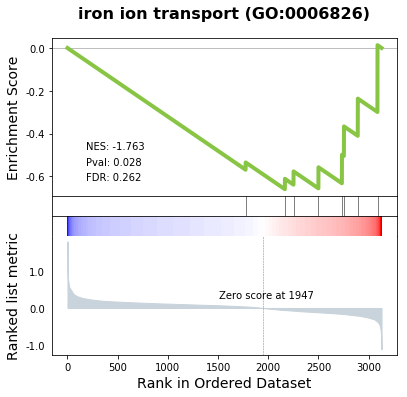

In [28]:
term = 'iron ion transport (GO:0006826)'
gp.gseaplot(rank_metric=pre_res.ranking,
         term=term,
            cmap = plt.cm.seismic_r,
         **pre_res.results[term])
figname = 'gseaplot_GOBP_iron_ion_transport.png'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'png',
            dpi=300,
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

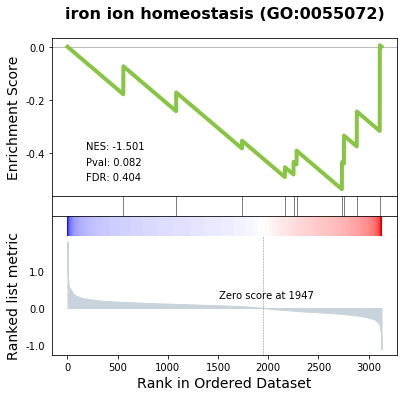

In [29]:
term = 'iron ion homeostasis (GO:0055072)'
gp.gseaplot(rank_metric=pre_res.ranking,
         term=term,
            cmap = plt.cm.seismic_r,
         **pre_res.results[term])
figname = 'gseaplot_GOBP_iron_ion_homeostasis.png'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'png',
            dpi=300,
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

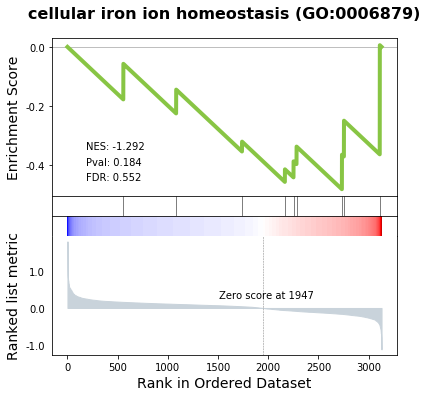

In [30]:
term = 'cellular iron ion homeostasis (GO:0006879)'
gp.gseaplot(rank_metric=pre_res.ranking,
         term=term,
            cmap = plt.cm.seismic_r,
         **pre_res.results[term])
figname = 'gseaplot_GOBP_cellular_iron_ion_transport.png'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'png',
            dpi=300,
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

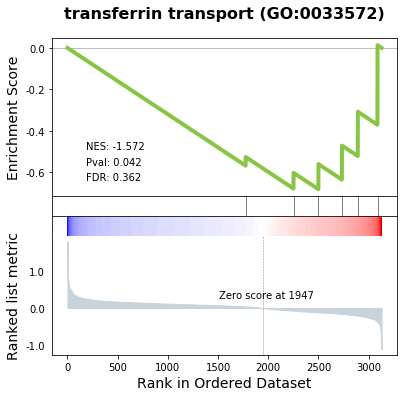

In [31]:
term = 'transferrin transport (GO:0033572)'
gp.gseaplot(rank_metric=pre_res.ranking,
         term=term,
            cmap = plt.cm.seismic_r,
         **pre_res.results[term])
figname = 'gseaplot_GOBP_transferrin_transport.png'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'png',
            dpi=300,
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

# Combined score dotplot of iron related gene sets (based on aged genes)

In [12]:
res_iron = pd.read_csv('%s/gene_sets_iron_aged.csv' % path_output, header=0, index_col=0)

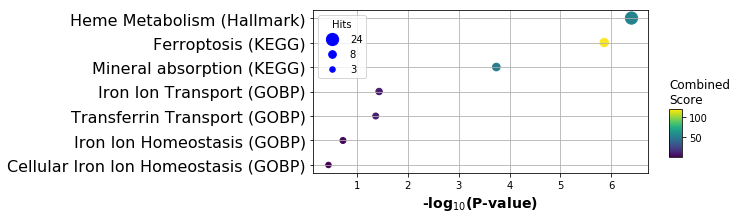

In [14]:
gp.plot.dotplot(res_iron, column='P-value', top_term=20, cutoff=1.0, cmap='viridis', figsize=(6, 3))
figname = 'dotplot_iron_genesets.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf',
            dpi=300,
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

# Projection of gene signatures

In [12]:
X = sc.read_h5ad('%s/%s_X_LUAD_aging_pp.h5' % (path_output, exp_id))

In [13]:
Xs = sc.read_h5ad('%s/%s_Xs_LUAD_aging_KP_tumor_subsampled.h5' % (path_output, exp_id))

In [14]:
cmap_epithelial_tumor = {'AT2-like': '#b2df8a',
                         'AT2': '#33a02c',
                         'High plasticity cell state': '#a50f15',
                         'AT1-like': '#fb6a4a',
                         'Ribosome high': '#c51b7d',
                         'Endoderm-like': '#542788',
                         'AT1': '#e6ab02',
                         'Ciliated':'#666666', 
                         'Other':'silver'}

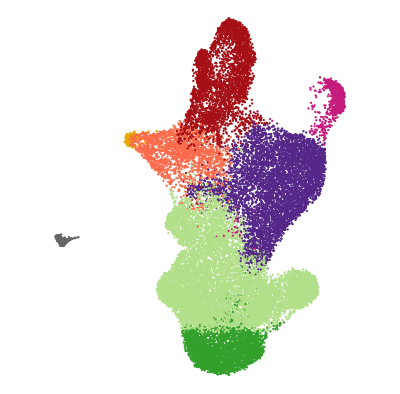

In [15]:
draw_scatter_groups(Xs.obsm['X_umap_pca'], 
                    Xs.obs['cl_epithelial_tumor_pca'],
                    cmap_epithelial_tumor,
                    s=5, show_axes=False, show_legend=False)

## Projection of marker genes

In [16]:
pdX = sc2pd(X, 'norm_log2')

In [17]:
gr_order = ['AT2',
            'AT2-like',
            'AT1-like',
            'High plasticity cell state',
            'Endoderm-like',
            'Ribosome high']

/var/folders/_6/p1hrwymj08j35qhr2dqvyg8h0000gp/T/ipykernel_3844/1420333078.py:11: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('%s/%s' % (path_figures, figname),


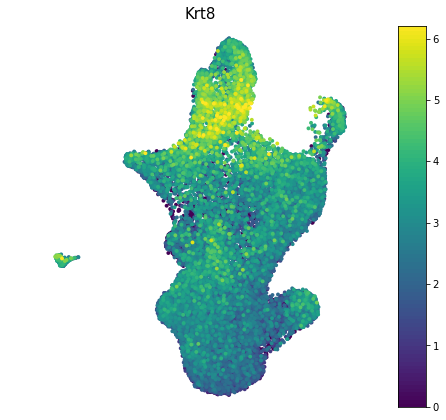

In [18]:
g = 'Krt8'
expr = pdX.loc[g, Xs.obs_names]
draw_scatter_expr(Xs.obsm['X_umap_pca'],
                  expr,
                  np.percentile(expr, 0.1),
                  np.percentile(expr, 99.9),
                  text = g,
                  s = 15, show_axes=False)

figname = 'umap_expr_Krt8.png'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'png',
            dpi=300,
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

In [19]:
c_sel = Xs.obs['cl_epithelial_tumor_pca'][Xs.obs['cl_epithelial_tumor_pca'].isin(gr_order)].index

/var/folders/_6/p1hrwymj08j35qhr2dqvyg8h0000gp/T/ipykernel_3844/2033685616.py:6: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('%s/%s' % (path_figures, figname),


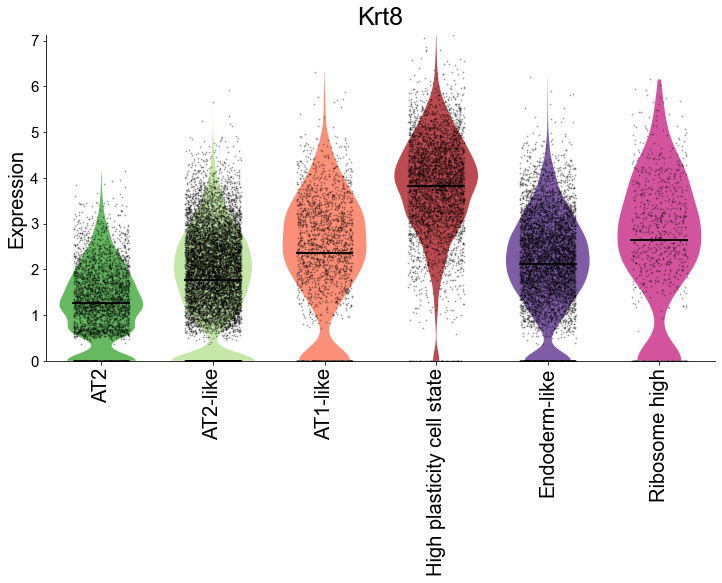

In [20]:
draw_violin(pdX.loc['Krt8'][c_sel], 
            Xs.obs['cl_epithelial_tumor_pca'][c_sel], 
            cmap_epithelial_tumor, gr_order, scatter=True)

figname = 'violin_expr_Krt8.png'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'png',
            dpi=300,
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

/var/folders/_6/p1hrwymj08j35qhr2dqvyg8h0000gp/T/ipykernel_3844/697356915.py:11: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('%s/%s' % (path_figures, figname),


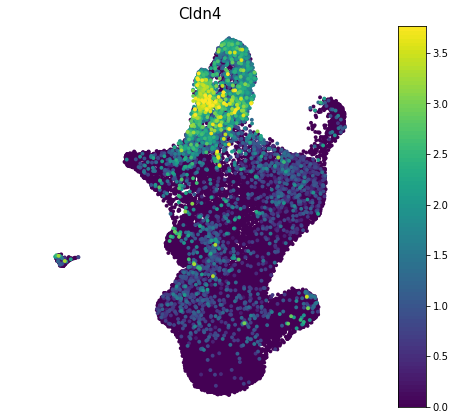

In [21]:
g = 'Cldn4'
expr = pdX.loc[g, Xs.obs_names]
draw_scatter_expr(Xs.obsm['X_umap_pca'],
                  expr,
                  np.percentile(expr, 0.1),
                  np.percentile(expr, 99.9),
                  text = g,
                  s = 15, show_axes=False)

figname = 'umap_expr_Cldn4.png'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'png',
            dpi=300,
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

/var/folders/_6/p1hrwymj08j35qhr2dqvyg8h0000gp/T/ipykernel_3844/2265640674.py:6: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('%s/%s' % (path_figures, figname),


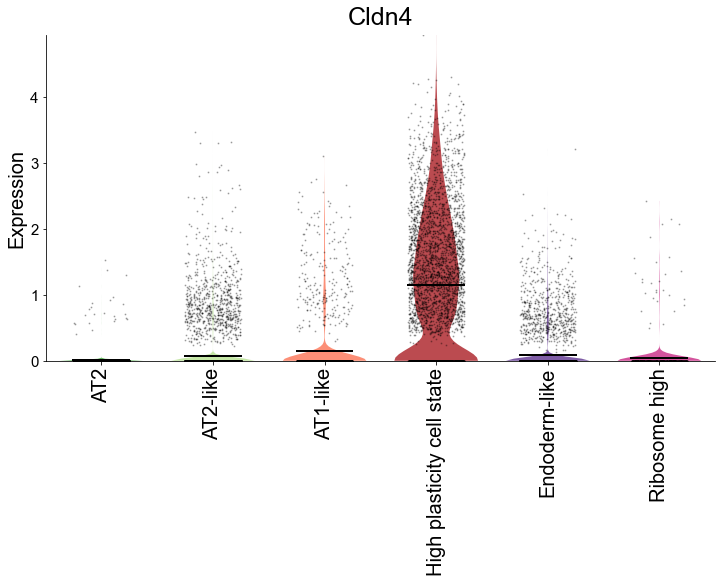

In [22]:
draw_violin(pdX.loc['Cldn4'][c_sel], 
            Xs.obs['cl_epithelial_tumor_pca'][c_sel], 
            cmap_epithelial_tumor, gr_order, scatter=True)

figname = 'violin_expr_Cldn4.png'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'png',
            dpi=300,
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

## Normalize data

In [23]:
sc.pp.normalize_total(X, target_sum=1e4)

## Get MaxAbs scaled data

In [24]:
from sklearn.preprocessing import MaxAbsScaler

In [25]:
X_scaled = X[Xs.obs_names]

In [26]:
X_scaled.X = MaxAbsScaler().fit_transform(X_scaled.X)

## Get signature scores

In [27]:
def draw_scatter_expr(coords, expr, vmin, vmax,text = None,  cmap = plt.cm.viridis, pad = 2, s = 50, 
                      show_axes = True, show_legend=True):

    
    #initialize figure
    
    height = 7
    width = 7.5
    plt.figure(facecolor = 'w', figsize = (width, height))
    gs = plt.GridSpec(1,2, wspace=0.025, width_ratios=[7,.5])

    #define x- and y-limits

    x_min, x_max = np.min(coords[:,0]), np.max(coords[:,0])
    y_min, y_max = np.min(coords[:,1]), np.max(coords[:,1])
    x_diff, y_diff = x_max - x_min, y_max - y_min
    x_cent, y_cent = x_min + 0.5 * x_diff, y_min + 0.5 * y_diff,

    pad = pad

    if x_diff > y_diff:
        xlim = (x_min - pad, x_max + pad)
        ylim = (y_cent - 0.5 * x_diff - pad, y_cent + 0.5 * x_diff + pad,)

    if x_diff < y_diff:
        xlim = (x_cent - 0.5 * y_diff - pad, x_cent + 0.5 * y_diff + pad,)
        ylim = (y_min - pad, y_max + pad)

    #define x- and y-axes

    ax = plt.subplot(gs[0])

    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim[0], ylim[1])
    
    #define colormap
            
    clist = np.array([cmap((e-vmin)/(vmax-vmin)) for e in expr])
    ixz = expr.argsort()
        
    #plot

    ax.scatter(coords[:,0][ixz],
               coords[:,1][ixz], 
               s = s,
               linewidth = 0.0,
               c = clist[ixz.values])
    
    #text
    
    if text:
        ax.text(xlim[0] + (xlim[1]-xlim[0]) / 2,
                ylim[1] * 1.05,
                text,
                fontsize = 15, va = 'center', ha = 'center')
        
    if not show_axes:
        clean_axis(ax)
    
    #plot colorbar
    
    if show_legend:

        ax = plt.subplot(gs[1])

        ax.set_xlim(0,1)
        ax.set_xticks([])

        ax.set_ylim(vmin, vmax)
        ax.yaxis.set_ticks_position('right')

        for i in np.linspace(vmin, vmax, 100):
            ax.axhspan(i, i + (vmax-vmin) / 100, color = cmap((i-vmin)/(vmax-vmin)))

## Strunz et al. 

In [28]:
dat = pd.read_excel('%s/Strunz.xlsx'%path_input, sheet_name='Supplementary Table 1', header=0)

464


/Users/simjoo/opt/anaconda3/envs/seacells/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/simjoo/opt/anaconda3/envs/seacells/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:175: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[score_name] = pd.Series(
/var/folders/_6/p1hrwymj08j35qhr2dqvyg8h0000gp/T/ipykernel_3844/802545688.py:18: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('%s/%s' % (path_figures, figname),


250


/Users/simjoo/opt/anaconda3/envs/seacells/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/var/folders/_6/p1hrwymj08j35qhr2dqvyg8h0000gp/T/ipykernel_3844/802545688.py:18: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('%s/%s' % (path_figures, figname),


458


/Users/simjoo/opt/anaconda3/envs/seacells/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/var/folders/_6/p1hrwymj08j35qhr2dqvyg8h0000gp/T/ipykernel_3844/802545688.py:18: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('%s/%s' % (path_figures, figname),


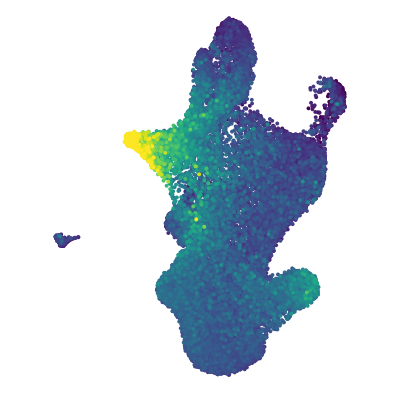

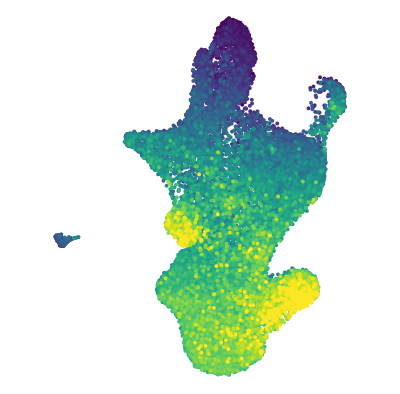

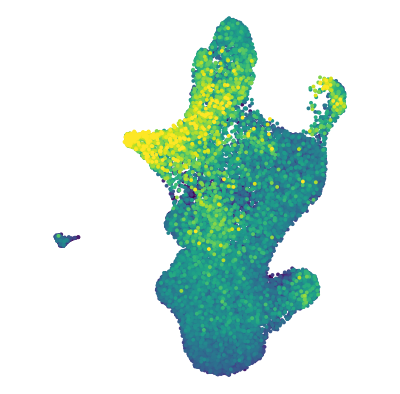

In [29]:
genes_Strunz = {}

for i in ['AT1 cells','AT2 cells','Krt8+ ADI']:
    g = 'Strunz et al. (2020) - %s' % i
    genes_tmp = dat['gene'][dat['annotated cluster']==i].values
    genes_tmp = [i for i in genes_tmp if i in X_scaled.var_names]
    print(len(genes_tmp))
    sc.tl.score_genes(X_scaled, genes_tmp, ctrl_size=len(genes_tmp), score_name=g)
    expr = X_scaled.obs[g][Xs.obs_names]
    draw_scatter_expr(Xs.obsm['X_umap_pca'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = '',
                  s = 15, show_axes=False, show_legend=False)

    figname = 'umap_score_%s.png' % g
    plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'png',
            dpi = 300,
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)
    

## Han et al. 

In [30]:
Han_clusters = {1:'AT2 Cell',14:'AT1 Cell',}

In [31]:
dat = pd.read_excel('%s/Han.xlsx'%path_input, sheet_name='Lung', header=0)

/Users/simjoo/opt/anaconda3/envs/seacells/lib/python3.8/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


332


/Users/simjoo/opt/anaconda3/envs/seacells/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/var/folders/_6/p1hrwymj08j35qhr2dqvyg8h0000gp/T/ipykernel_3844/4122733184.py:16: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('%s/%s' % (path_figures, figname),


327


/Users/simjoo/opt/anaconda3/envs/seacells/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/var/folders/_6/p1hrwymj08j35qhr2dqvyg8h0000gp/T/ipykernel_3844/4122733184.py:16: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('%s/%s' % (path_figures, figname),


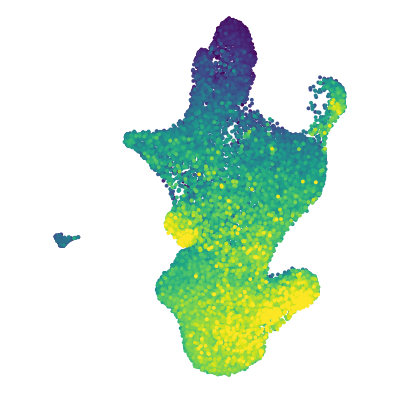

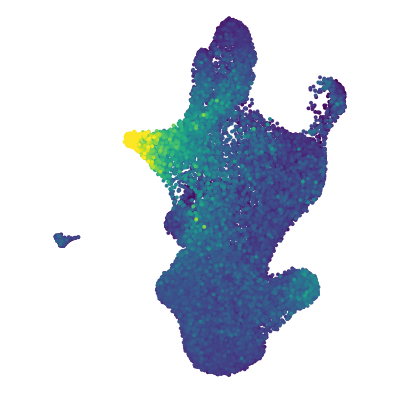

In [32]:
for i in [1,14]:
    g = 'Han et al. (2018) - %s' % Han_clusters[i]
    genes_tmp = dat['gene'][dat['cluster']==i].values
    genes_tmp = [i for i in genes_tmp if i in X_scaled.var_names]
    print(len(genes_tmp))
    sc.tl.score_genes(X_scaled, genes_tmp, ctrl_size=len(genes_tmp), score_name=g)
    expr = X_scaled.obs[g][Xs.obs_names]
    draw_scatter_expr(Xs.obsm['X_umap_pca'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = '',
                  s = 15, show_axes=False, show_legend=False)

    figname = 'umap_score_%s.png' % g
    plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'png',
            dpi = 300,
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)
    

# Kobayashi

In [33]:
genes_Kobayashi = open('%s/Kobayashi.txt' % path_input, 'r').read().split('>')

105


/Users/simjoo/opt/anaconda3/envs/seacells/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/var/folders/_6/p1hrwymj08j35qhr2dqvyg8h0000gp/T/ipykernel_3844/3920071538.py:16: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('%s/%s' % (path_figures, figname),


825


/Users/simjoo/opt/anaconda3/envs/seacells/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/var/folders/_6/p1hrwymj08j35qhr2dqvyg8h0000gp/T/ipykernel_3844/3920071538.py:16: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('%s/%s' % (path_figures, figname),


1303


/Users/simjoo/opt/anaconda3/envs/seacells/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/var/folders/_6/p1hrwymj08j35qhr2dqvyg8h0000gp/T/ipykernel_3844/3920071538.py:16: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('%s/%s' % (path_figures, figname),


567


/Users/simjoo/opt/anaconda3/envs/seacells/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/var/folders/_6/p1hrwymj08j35qhr2dqvyg8h0000gp/T/ipykernel_3844/3920071538.py:16: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('%s/%s' % (path_figures, figname),


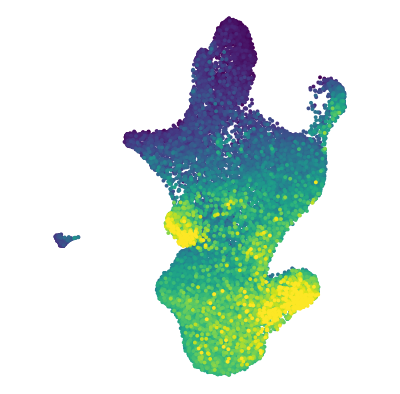

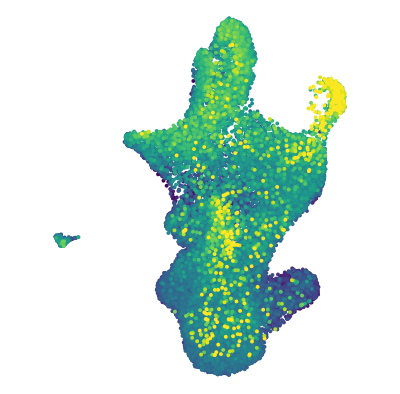

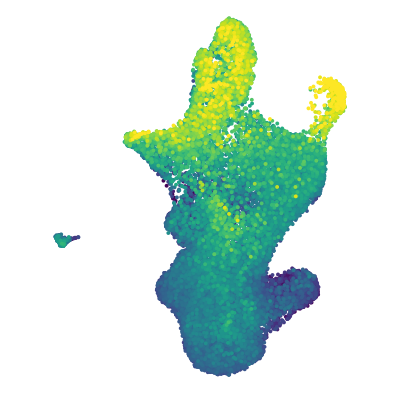

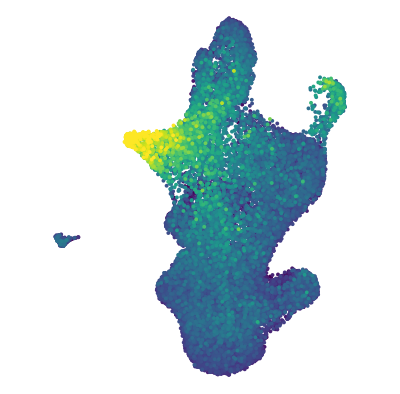

In [34]:
for i in genes_Kobayashi[1:]:
    g = 'Kobayashi et al. (2020) - %s' % i.split()[0]
    genes_tmp = i.split()[1:]
    genes_tmp = [i for i in genes_tmp if i in X_scaled.var_names]
    print(len(genes_tmp))
    sc.tl.score_genes(X_scaled, genes_tmp, ctrl_size=len(genes_tmp), score_name=g)
    expr = X_scaled.obs[g][Xs.obs_names]
    draw_scatter_expr(Xs.obsm['X_umap_pca'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = '',
                  s = 15, show_axes=False, show_legend=False)

    figname = 'umap_score_%s.png' % g
    plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'png',
            dpi = 300,
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

# Bischoff

In [35]:
genes_Bischoff = open('%s/Bischoff.txt' % path_input, 'r').read().split('>')

29


/Users/simjoo/opt/anaconda3/envs/seacells/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/var/folders/_6/p1hrwymj08j35qhr2dqvyg8h0000gp/T/ipykernel_3844/1112660864.py:16: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('%s/%s' % (path_figures, figname),


22


/Users/simjoo/opt/anaconda3/envs/seacells/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/var/folders/_6/p1hrwymj08j35qhr2dqvyg8h0000gp/T/ipykernel_3844/1112660864.py:16: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('%s/%s' % (path_figures, figname),


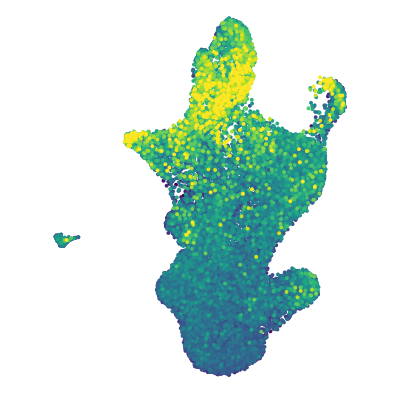

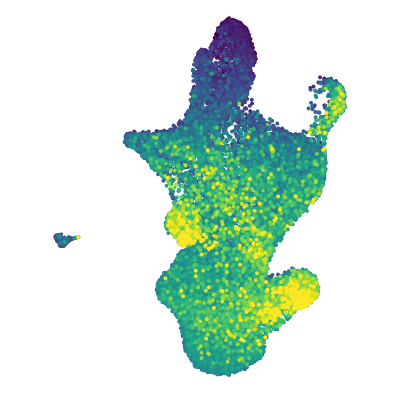

In [36]:
for i in genes_Bischoff[1:]:
    g = 'Bischoff et al. (2021) - %s' % i.split()[0]
    genes_tmp = i.split()[1:]
    genes_tmp = [i.capitalize() for i in genes_tmp if i.capitalize() in X_scaled.var_names]
    print(len(genes_tmp))
    sc.tl.score_genes(X_scaled, genes_tmp, ctrl_size=len(genes_tmp), score_name=g)
    expr = X_scaled.obs[g][Xs.obs_names]
    draw_scatter_expr(Xs.obsm['X_umap_pca'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = '',
                  s = 15, show_axes=False, show_legend=False)

    figname = 'umap_score_%s.png' % g
    plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'png',
            dpi = 300,
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

In [37]:
genes_Choi = open('%s/Choi.txt' % path_input, 'r').read().split('>')

6


/Users/simjoo/opt/anaconda3/envs/seacells/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/var/folders/_6/p1hrwymj08j35qhr2dqvyg8h0000gp/T/ipykernel_3844/2947909120.py:16: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('%s/%s' % (path_figures, figname),


6


/Users/simjoo/opt/anaconda3/envs/seacells/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/var/folders/_6/p1hrwymj08j35qhr2dqvyg8h0000gp/T/ipykernel_3844/2947909120.py:16: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('%s/%s' % (path_figures, figname),


2


/Users/simjoo/opt/anaconda3/envs/seacells/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/var/folders/_6/p1hrwymj08j35qhr2dqvyg8h0000gp/T/ipykernel_3844/2947909120.py:16: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('%s/%s' % (path_figures, figname),


7


/Users/simjoo/opt/anaconda3/envs/seacells/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/var/folders/_6/p1hrwymj08j35qhr2dqvyg8h0000gp/T/ipykernel_3844/2947909120.py:16: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('%s/%s' % (path_figures, figname),


3


/Users/simjoo/opt/anaconda3/envs/seacells/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/var/folders/_6/p1hrwymj08j35qhr2dqvyg8h0000gp/T/ipykernel_3844/2947909120.py:16: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('%s/%s' % (path_figures, figname),


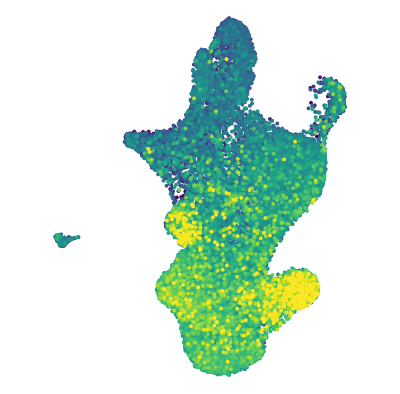

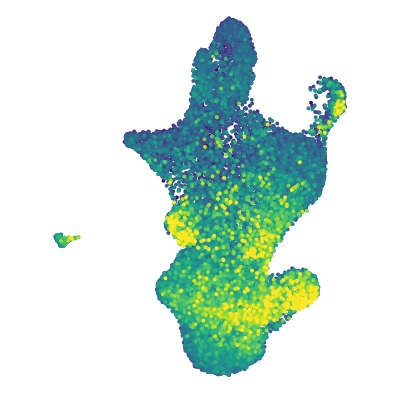

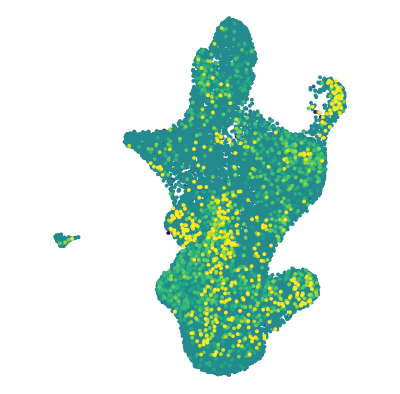

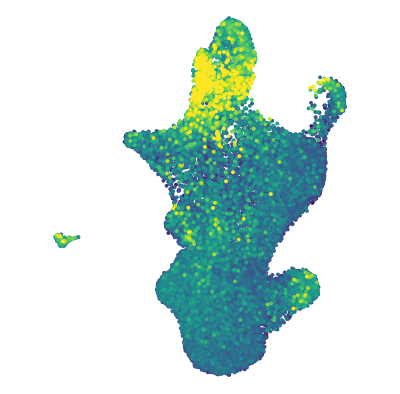

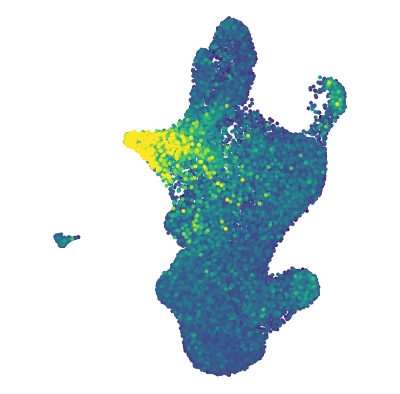

In [38]:
for i in genes_Choi[1:]:
    g = 'Choi et al. (2020) - %s' % i.split()[0]
    genes_tmp = i.split()[1:]
    genes_tmp = [i.capitalize() for i in genes_tmp if i.capitalize() in X_scaled.var_names]
    print(len(genes_tmp))
    sc.tl.score_genes(X_scaled, genes_tmp, ctrl_size=len(genes_tmp), score_name=g)
    expr = X_scaled.obs[g][Xs.obs_names]
    draw_scatter_expr(Xs.obsm['X_umap_pca'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = '',
                  s = 15, show_axes=False, show_legend=False)

    figname = 'umap_score_%s.png' % g
    plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'png',
            dpi = 300,
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

# Heatmap

/var/folders/_6/p1hrwymj08j35qhr2dqvyg8h0000gp/T/ipykernel_3844/126774288.py:66: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('%s/%s' % (path_figures, figname),


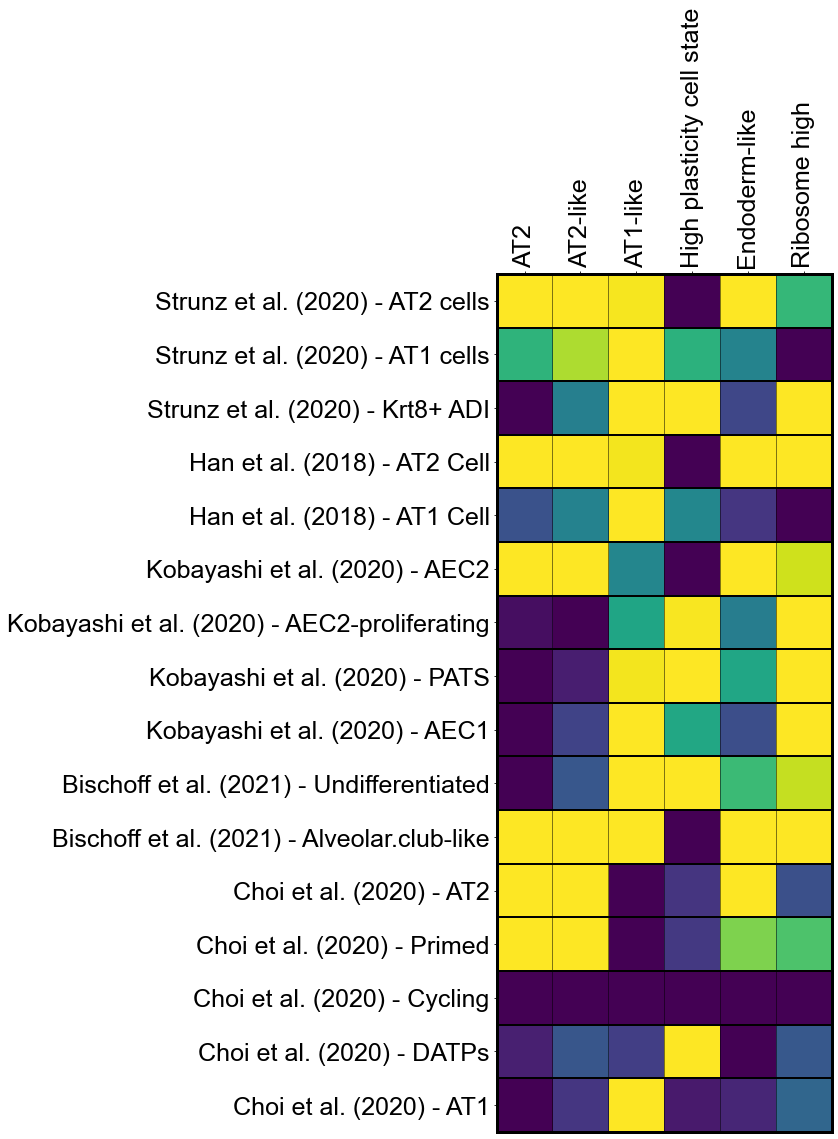

In [53]:
columns = gr_order
rows = [
        'Strunz et al. (2020) - AT2 cells',
        'Strunz et al. (2020) - AT1 cells',
        'Strunz et al. (2020) - Krt8+ ADI', 
    'Han et al. (2018) - AT2 Cell', 
    'Han et al. (2018) - AT1 Cell', 
    'Kobayashi et al. (2020) - AEC2',
    'Kobayashi et al. (2020) - AEC2-proliferating',
    'Kobayashi et al. (2020) - PATS',
    'Kobayashi et al. (2020) - AEC1',
    'Bischoff et al. (2021) - Undifferentiated',
    'Bischoff et al. (2021) - Alveolar.club-like',
    'Choi et al. (2020) - AT2',
    'Choi et al. (2020) - Primed',
    'Choi et al. (2020) - Cycling',
    'Choi et al. (2020) - DATPs',
    'Choi et al. (2020) - AT1']

dat = pd.DataFrame(index = rows, columns = columns)
for i in dat.index:
    for c in dat.columns:
        c_sel = Xs.obs['cl_epithelial_tumor_pca'][Xs.obs['cl_epithelial_tumor_pca']==c].index
        dat.loc[i,c] = X_scaled.obs.loc[c_sel, i].median()
        
dat = dat.apply(lambda x: (x-np.min(x))/(np.max(x)-np.min(x)), axis=1).fillna(0)

#initialize figure

height = 1 * len(dat.index) + 2 + 0.05
width = 1 * len(dat.columns)

plt.figure(facecolor = 'w', figsize = (width, height))
gs = plt.GridSpec(3,1, hspace=0.025, height_ratios=[1 * len(rows), 1, 1])

ax = plt.subplot(gs[0])
    
#plot data

ax.imshow(dat.astype(float), vmin = 0, vmax = 0.5, cmap = plt.cm.viridis, aspect = 'auto')

# plot gene names

ax.set_yticks(range(len(rows)))
ax.set_yticklabels([i.split('_')[0] for i in rows], fontsize = 25, family = 'Arial')

#plot group names

ax.set_xticks(range(len(columns)))
ax.set_xticklabels([i for i in columns], fontsize = 25, family = 'Arial', rotation = 'vertical')
ax.xaxis.set_ticks_position('top')

# plot grid

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
    ax.spines[axis].set_color('k')
    
for y in range(len(rows)):
    ax.axhline(y+0.5, linewidth = 2, color = 'k')

for x in range(len(columns)):
    ax.axvline(x+0.5, linewidth = 0.5, color = 'k')

figname = 'heatmap_scores.png'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'png',
            dpi = 300,
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)